# Homework 3 - Andrew Schwartz - PHYS 403, SPR 2024

## 1. Properties of the Poisson Distribution 

Here you will verify three properties of the Poisson distribution
$$
p(m|\lambda)=\frac{\lambda^m}{m!}e^{-\lambda}
$$

### (a)

Show that $\langle m\rangle=\lambda$.

### Solution



### (b)

Show that $\text{var}(m)=\lambda$.

### Solution

### (c)

Suppose $x$ and $y$ are independent Poisson variables with means $λ_x$ and $λ_y$, respectively. Show that $z = x + y$ is also Poisson-distributed with mean $λ_z = λ_x + λ_y$, thus proving that the sum of two Poisson variables is another Poisson variable.


*Hint:* consider the joint probability $p(x, y|λ_x, λ_y)$. Noting that $x + y = z$, sum over all $x \in [0, z]$ such that $z = x + y$.

### Solution

## 2. Generating Gaussian Random Numbers

In class we discussed several different ways to generate Gaussian random numbers. In this problem, we will implement these methods to generate Gaussian random numbers with $\mu = 0$ and $σ^2 = 1$. Make sure that all plots are properly labeled.

In [3]:
try:
    import cupy as np
except ImportError:
    import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, rayleigh

n = 10_000

In [16]:
def add_pdf(ax, dist, min=None, max=None, **kwargs):
    x = np.linspace(
        min if min is not None else dist.ppf(0.001),
        max if max is not None else dist.ppf(0.999),
        1000
    )
    ax.plot(x, dist.pdf(x, **kwargs))


def plot(gaussian):
    fig, ax = plt.subplots()
    ax.hist(gaussian(), density=True, bins=31, label="simulated")
    add_pdf(ax, norm)
    ax.set_title(gaussian.__name__)
    ax.set_xlabel("x (units of σ)")
    ax.set_ylabel("Probability")
    plt.show()

### (a)

Write a function that uses the accept/reject method. Generate 10,000 random numbers, and plot them to show that they are Gaussian distributed. (Warning: this will be very slow if you try to go out to large values of $|x|$, so you may want to restrict the region to within a few $σ$ of the mean.)

len(gaussian_rejection()) = 2600


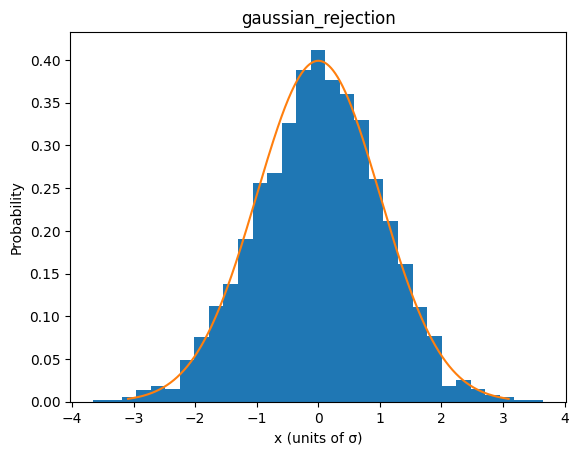

In [113]:
def gaussian_rejection():
    σs = 5
    max_value = norm.pdf(0)
    x = np.random.uniform(-σs, σs, n)
    y = np.random.uniform(0, max_value, n)
    return x[y < norm.pdf(x)]

print(f'len(gaussian_rejection()) = {len(gaussian_rejection())}')
plot(gaussian_rejection)

### (b)

Write a function that uses the central limit theorem, and random numbers generated from a uniform distribution. Generate 10,000 Gaussian random numbers, and plot the result.

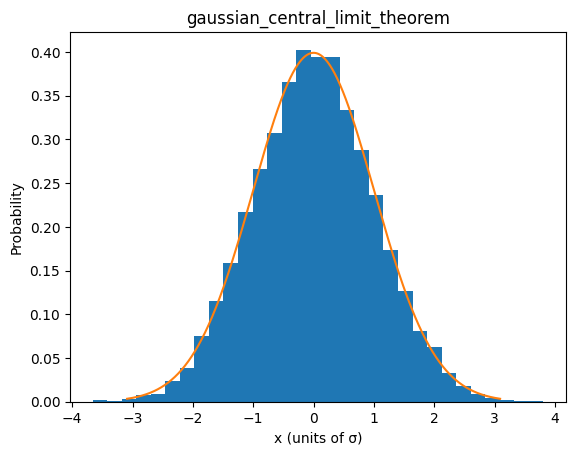

In [18]:
def gaussian_central_limit_theorem():
    return np.sum(np.random.uniform(size=(n, 12)), axis=1) - 6


plot(gaussian_central_limit_theorem)

### (c)

Write a function that applies the classic version of the Box-Müller algorithm. Generate 10,000 random numbers, and plot the result. (Hint: your function will actually produce pairs of independent random numbers, so you get two for each call.)

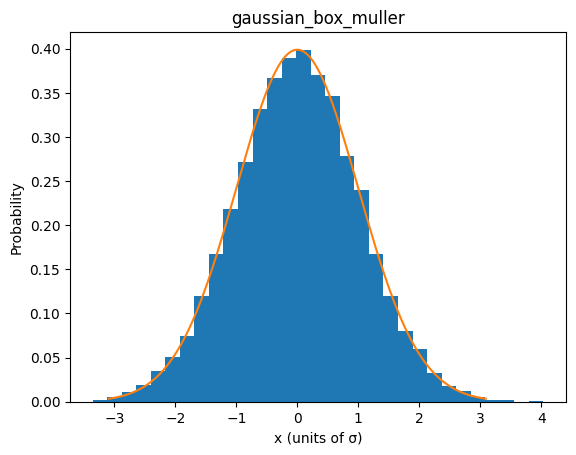

In [19]:
def gaussian_box_muller(concat=True):
    θ = np.random.uniform(0, 2 * np.pi, n // 2)
    u = np.random.uniform(size=n // 2)
    r = np.sqrt(-2 * np.log(u))
    if concat is None:
        return r, θ
    x = r * np.cos(θ)
    y = r * np.sin(θ)
    return np.concatenate((x, y)) if concat else (x, y)


plot(gaussian_box_muller)

### (c)

Using your Box-Müller function, show that the $x, y$ pair are independent. (Hint: make a 2D scatter plot.)

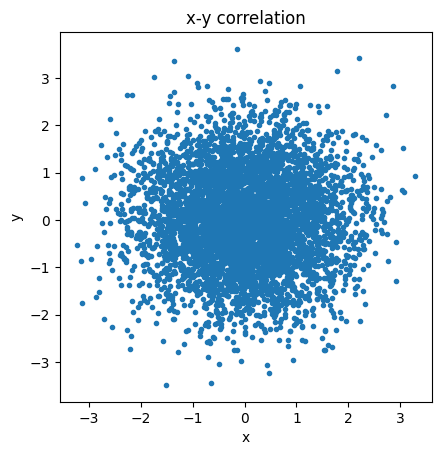

In [20]:
x, y = gaussian_box_muller(concat=False)
fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax.scatter(x, y, marker='.')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("x-y correlation")
plt.show()

### (d)

Modify your Box-Müller function to return polar variables. Show that $θ$ is distributed uniformly, and $r$ is a Rayleigh distribution.

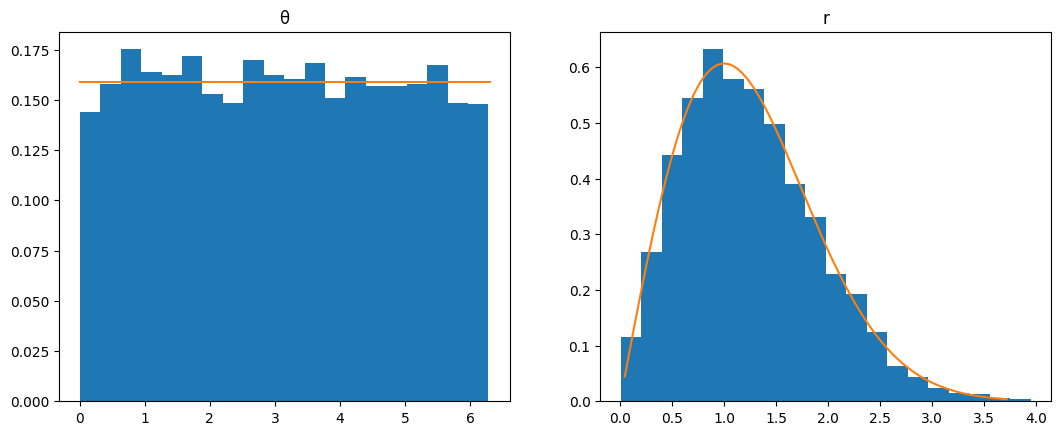

In [27]:
r, θ, = gaussian_box_muller(concat=None)
fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
ax[0].hist(θ, density=True, bins=20, label="θ")
ax[0].set_title("θ")
add_pdf(ax[0], uniform, max=6.3, scale=6.3)
ax[1].hist(r, density=True, bins=20, label="r")
ax[1].set_title("r")
add_pdf(ax[1], rayleigh)
plt.show()

### (f)

Write a function that implements the Marsaglia method. Show that it also produces pairs of independent, Gaussian distributed random numbers.

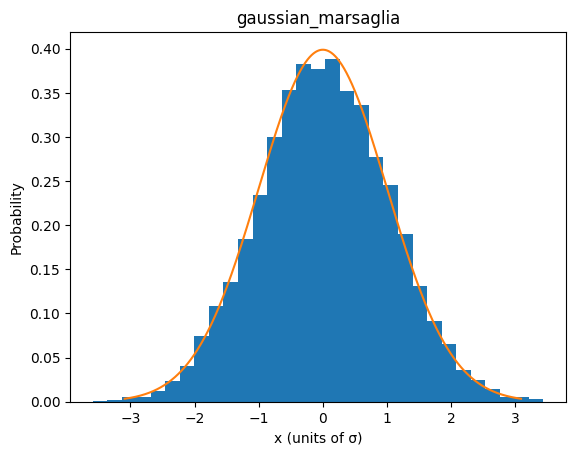

In [103]:
def gaussian_box_muller_fast():
    θ = np.random.uniform(0, 2 * np.pi, n // 2)
    u = np.random.uniform(size=n // 2)
    r = np.sqrt(-2 * np.log(u))
    x = r * np.cos(θ)
    y = r * np.sin(θ)
    return np.concatenate((x, y))


def gaussian_marsaglia():
    xy = np.random.uniform(-1, 1, (2, n // 2))
    s = np.sum(xy ** 2, axis=0)
    accept = s <= 1
    xy = xy[:, accept]
    s = s[accept]
    r = np.sqrt(-2 * np.log(s) / s)
    return np.reshape(r * xy, -1)
    # return np.concatenate((x, y)) if concat else (x, y)


plot(gaussian_marsaglia)

# x, y = gaussian_marsaglia()
# print(f'len(x) = {len(x)}')
# fig, ax = plt.subplots(figsize=(4.8, 4.8))
# ax.scatter(x, y, marker='.')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_title("x-y correlation")
# plt.show()

### (g)

Extra credit: Determine the time performance of each technique in this problem to generate a very large sequence of Gaussian random numbers (there are many ways to do this, you can use the UNIX time command, or python’s time package, for example). Compare the result to a built-in Gaussian RNG (like numpy.random.normal). Quantify what is meant by some things being “slow.”

In [114]:
from timeit import timeit
from prettytable import PrettyTable

iters = 10_000

def gaussian_numpy():
    return np.random.normal(size = n)

functions = [
    gaussian_numpy,
    gaussian_rejection,
    gaussian_central_limit_theorem,
    gaussian_box_muller,
    gaussian_box_muller_fast,
    gaussian_marsaglia
]

t = PrettyTable(["functions", "time (s)"])
t.add_rows([[fn.__name__, timeit(fn, number=iters)] for fn in functions])
print(t)

+--------------------------------+--------------------+
|           functions            |      time (s)      |
+--------------------------------+--------------------+
|         gaussian_numpy         | 2.2428282000000763 |
|       gaussian_rejection       | 8.219522400000187  |
| gaussian_central_limit_theorem | 9.397700600000007  |
|      gaussian_box_muller       | 2.240503600000011  |
|    gaussian_box_muller_fast    | 2.2213284999997995 |
|       gaussian_marsaglia       | 2.3424667999997837 |
+--------------------------------+--------------------+


## 3. Monte Carlo Integration: the Gamma Function

The integral of a 1D function f(x) on the interval [a, b] can be approximated by
$$
I=\int_a^bf(x)dx\approx(b-a)\langle f(x)\rangle,\qquad\qquad\langle f(x)\rangle\frac{1}{N}\sum_{i=1}^Nf(x_i),
$$
where the ${x_i}$ are a set of random uniformly distributed points on the interval $a\leq x\leq b$. The uncertainty on the integral is approximately
$$
\Delta I\approx(b-a)\sqrt{\frac{\langle f^2(x)\rangle-\langle f(x)\rangle^2}{N}}.
$$
The gamma function is defined by
$$
\Gamma(z)=\int_0^\infty x^{z-1}e^{-x}dx
$$
where z can be a complex number in general. For simplicity, let's assume z is real.

*Hint:* for integer values, $\Gamma(n) = (n − 1)!$, the factorial function. You can use this to check your implementation of the gamma function.

*Hint:* to transform the infinite range of integration to a finite one, you may wish to make the change of variables $u = 1/(1 + x)$.


### (a)

Write a function to compute $\Gamma(z)$ and the uncertainty on $\Gamma(z)$ using Monte Carlo integration.

### (b)

Compute $\Gamma(5)$ and $\Gamma(\pi)$ using 100, $10^4$, and $10^6$ samples, and report the uncertainties. (Reporting the values to about 6 significant figures should be sufficient.)

### (c)

Using $10^6$ samples, compute $\Gamma(90)$. Do you encounter a numerical overflow? How might you change your code to avoid this? Make the change and compute $\Gamma(90)$.
